In [1]:
from sklearn import decomposition
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.cluster import adjusted_rand_score
from datetime import datetime as dt
from datetime import timedelta as td
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
df = pd.read_csv('raw_data.csv')

# Jeu de donnee
Pour cette partie nous allons repartir du jeu de donnee netoyer et regrouper par *merge* et nous allons recalculer les variables pour la segmentation recursivement. Nous allons presenter 2 simulations de maintenances pour les 2 modeles les plus pertinents


1- Le model classique Recency - Frequency - Monetary

2- Le model  Recency - Frequency - Monetary - nbre of items

In [2]:
df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,payment_value,payment_installments,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,order_item_id
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02,2017-10-02,2017-10-04,2017-10-10,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,38.71,1,a54f0611adc9ed256b57ede6b6eb5114,4,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48,1
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24,2018-07-26,2018-07-26,2018-08-07,2018-08-13,af07308b275d755c9edb36a90c618231,141.46,1,8d5266042046a06655c8db133d120ba5,4,Muito boa a loja,Muito bom o produto.,2018-08-08 00:00:00,2018-08-08 18:37:50,1
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08,2018-08-08,2018-08-08,2018-08-17,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,179.12,3,e73b67b67587f7644d5bd1a52deb1b01,5,NaN,NaN,2018-08-18 00:00:00,2018-08-22 19:07:58,1
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18,2017-11-18,2017-11-22,2017-12-02,2017-12-15,7c142cf63193a1473d2e66489a9ae977,72.20,1,359d03e676b3c069f62cadba8dd3f6e8,5,NaN,O produto foi exatamente o que eu esperava e e...,2017-12-03 00:00:00,2017-12-05 19:21:58,1
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13,2018-02-13,2018-02-14,2018-02-16,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,28.62,1,e50934924e227544ba8246aeb3770dd4,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 13:02:51,1


In [3]:
df.shape

(97916, 18)

## Generation du premier df0
Ce dataset est le dataset initial de toutes les commandes jusqu'au 31/12/2017. Nous recupererons la premiere latest_date pour initier la boucle du calcul de la stabilite du model

In [4]:
df0 = df[df['order_purchase_timestamp'] <= '2017-12-31']

In [5]:
df0['order_purchase_timestamp'] = pd.to_datetime(
    df0['order_purchase_timestamp'], format="%Y-%m-%d %H:%M:%S").dt.date
latest_date_init = df0['order_purchase_timestamp'].max() + td(days=1)
latest_date_init

datetime.date(2018, 1, 1)

In [6]:
df['order_purchase_timestamp'] = pd.to_datetime(
    df['order_purchase_timestamp'], format="%Y-%m-%d %H:%M:%S").dt.date

# 1- Le modele RFM
On cree uns fonction get_rfm qui va calculer les variables recency, frequency et monetary a partir du dataset d'entree X qui pourra etre le dataset initial df0 ou le dataset dans j+15 df1. Cette fonction retournera le dataset rfm (rfm0 ou rfm1 suivant le cas)

In [7]:
def get_rfm(X, latest_date):
    '''
    Returns the rfm dataset computed from the the dataset generated from X using the date latest_date.

            Parameters:
                    X (PandaFrame) : A dataframe
                    latest_date (datetime): The latest date for order_purchase_timestamp used to compute recency


            Returns:
                    rfm : The dataframe containing the variables recency, frenquency and monetary 
    '''

    rfm = X.groupby('customer_unique_id').agg(
        {'order_purchase_timestamp': lambda x: (latest_date - x.max()), 'order_id': lambda x: x.count(), 'payment_value': lambda x: x.sum()})

    rfm = rfm.rename(columns={'order_purchase_timestamp': 'recency',
                              'order_id': 'frequency', 'payment_value': 'monetary'})
    return rfm

## Normalisation des variables
Avant d'utiliser le kmeans nous normalisons les variables. Pour cela je cree 2 piplines: full_pipeline0 est le pipeline qui sera *fitted* sur le rfm0 initial et donc sera utiliser ulteriorement pour normaliser rfm1 (pour le calcul de C_init les labels de rfm1 calculee a partir du model sur rfm0) et full_pipeline1 qui sera directement utiliser dur rfm1 (fit_predict) dans le cadre du calcul de C1 (les labels a partir du nouveau model sur rfm1)

In [8]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
normal = ['recency']
skewed = ['frequency', 'monetary']
scaler = StandardScaler()
log_pipeline = Pipeline(steps=[('transformer', FunctionTransformer(
    np.log1p)), ('scaler', StandardScaler())])
full_pipeline0 = ColumnTransformer(
    [('normal', StandardScaler(), normal), ('skewed', log_pipeline, skewed)])
full_pipeline1 = ColumnTransformer(
    [('normal', StandardScaler(), normal), ('skewed', log_pipeline, skewed)])

## Calcul des Ari score
Je cree une fonction recursive qui vas calculer les ari score entre C_init et C1 d'une facon periodique. En d'autre termes, a chaque fois que le ari score devient inferieur a 0.8, un nouveau df0 est generee a cette date et une nouvelle iteration de calcul de ari score est lancee. 

In [30]:
def comp_score(func, latest_date_init, n_clusters):
    '''
        Compute recursively the periods of maitenance, whnever the ari score drop below 0.8 a new initial dataset 
        df0 is generated and a new set of ari scores is computed. It returns the score table with the recursive 
        maitenance periods.

                Parameters:
                        func : A function to compute the aggregation of variables (get_rfm or get_rfmnb in our case)
                        latest_date_init (datetime): The latest date in the initial dataset df0
                        n_clusters (int): An integer indicating the number of clusters to use in the kmeans model


                Returns:
                        score : The dataframe containing the ari score by date
        '''

    ari = 1
    k = 0
    score = pd.DataFrame()
    score[0] = [latest_date_init, 0, 1]

    while df['order_purchase_timestamp'].max() > score.transpose()[0].max():
        df0 = df[df['order_purchase_timestamp'] < score.transpose()[0].max()]
        latest_date = df0['order_purchase_timestamp'].max() + td(days=1)
        rfm0 = func(df0, latest_date)
        full_pipeline0.fit(rfm0)
        rfm0_scaled = full_pipeline0.transform(rfm0)

        kmeans0 = KMeans(n_clusters=n_clusters)
        kmeans0.fit_predict(rfm0_scaled)
        k0 = 0
        ari = 1
        while ari > 0.8 and df['order_purchase_timestamp'].max() > score.transpose()[0].max():
            k = k+15
            k0 = k0+15
            t1 = df0['order_purchase_timestamp'].max() + td(days=k0)
            df1 = df[df['order_purchase_timestamp'] < t1]
            latest_date = df1['order_purchase_timestamp'].max() + td(days=1)
            rfm1 = func(df1, latest_date)
            rfm1_scaled = full_pipeline1.fit_transform(rfm1)
            kmeans1 = KMeans(n_clusters=n_clusters)
            c1_new = kmeans1.fit_predict(rfm1_scaled)
            rfm1_init_scaled = full_pipeline0.transform(rfm1)
            c1_init = kmeans0.predict(rfm1_init_scaled)
            ari = adjusted_rand_score(c1_new, c1_init)
            score[k] = [t1, k0, ari]
    return score

In [10]:
score = comp_score(get_rfm, latest_date_init, 4)

## Resultats:
Pour afficher les resultats j'utilise la fonction maintenance_plt qui va a partir de la table de score generer precedemment donner le graphe des periodes de stabilite du modele calculee recursivement. Cela nous donnera une idee de la longueur moyenne des periodes de stabilite. 

In [11]:
def maintenance_plt(score, model):
    '''
    Returns the plot of the maintenance simulation Ari score on 15 days periods 
    along with the table for the ari score by period and date. 

            Parameters:
                    score : A dataframe
                    model (str): The name of the model used in the simulation


            Returns:
                    score_t : The dataframe containing the ari score by date
    '''
    score_t = score.transpose()
    score_t = score_t.drop(index=[0])
    score_t = score_t.rename(columns={0: 'Date', 1: 'T1', 2: 'ARI score'})
    score_t[['Date', 'ARI score']].plot(x='Date', figsize=(22, 4), grid=True)
    plt.axhline(y=0.8, c="red", linewidth=2, zorder=0)
    plt.xticks(score_t['Date'])
    plt.title('Maintenance simulation plot for the model : ' + model)
    plt.show()
    return score_t

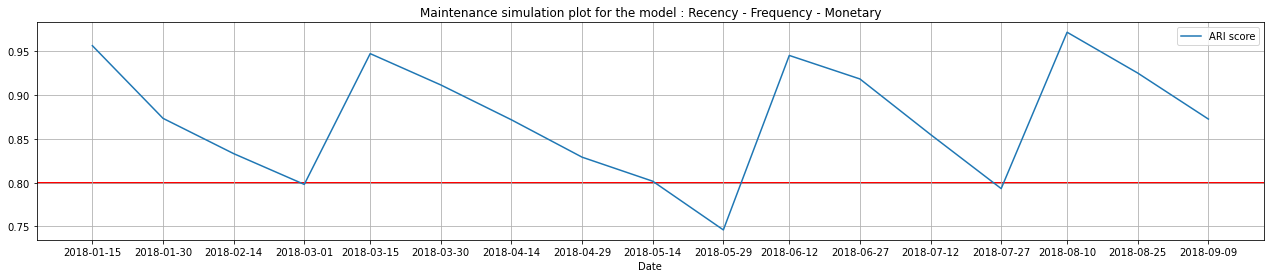

,Date,T1,ARI score
15,2018-01-15,15,0.956574
30,2018-01-30,30,0.873567
45,2018-02-14,45,0.833252
60,2018-03-01,60,0.798077
75,2018-03-15,15,0.947489
90,2018-03-30,30,0.911704
105,2018-04-14,45,0.871857
120,2018-04-29,60,0.82919
135,2018-05-14,75,0.801713
150,2018-05-29,90,0.746079


In [12]:
maintenance_plt(score, 'Recency - Frequency - Monetary')

# 2- Le model Recency Frequency Monetary Nbre_of_items
Il est interessant de voir aussi la simulation de maintenance de ce model comme il presente une segmantation de client assez interessante en s'interessent aux grand acheteurs (c a d les clients qui meme si pas frequents mais ont achete plussieurs articles dans leur commande). Pour cela on cree la fonction get_rfmnb() et on utilise directement les fonctions qu'on a definit pour le calcul et la representation des scores

In [13]:
def get_rfmnb(X, latest_date):
    '''
    Returns the rfmnb dataset computed from the the dataset generated from X using the date latest_date.

            Parameters:
                    X (PandaFrame) : A dataframe
                    latest_date (datetime): The latest date for order_purchase_timestamp used to compute recency


            Returns:
                    rfm : The dataframe containing the variables recency, frenquency , monetary and nbre of items 
    '''

    rfm = X.groupby('customer_unique_id').agg(
        {'order_purchase_timestamp': lambda x: (latest_date - x.max()), 'order_id': lambda x: x.count(),
         'payment_value': lambda x: x.sum(), 'order_item_id': lambda x: x.sum()})
    rfm = rfm.rename(columns={'order_purchase_timestamp': 'recency',
                              'order_id': 'frequency', 'payment_value': 'monetary', 'order_item_id': 'nbre_of_items'})
    return rfm

In [14]:
normal = ['recency']
skewed = ['frequency', 'monetary', 'nbre_of_items']
scaler = StandardScaler()
log_pipeline = Pipeline(steps=[('transformer', FunctionTransformer(
    np.log1p)), ('scaler', StandardScaler())])
full_pipeline0 = ColumnTransformer(
    [('normal', StandardScaler(), normal), ('skewed', log_pipeline, skewed)])
full_pipeline1 = ColumnTransformer(
    [('normal', StandardScaler(), normal), ('skewed', log_pipeline, skewed)])

In [31]:
score_plus = comp_score(get_rfmnb, latest_date_init, 5)

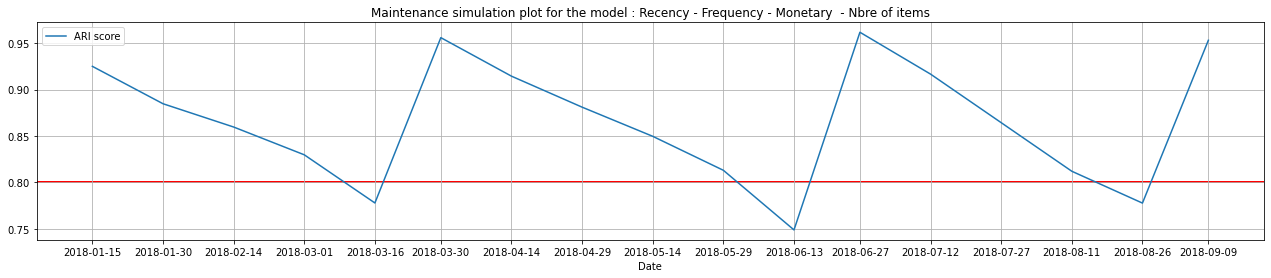

,Date,T1,ARI score
15,2018-01-15,15,0.925116
30,2018-01-30,30,0.884796
45,2018-02-14,45,0.859686
60,2018-03-01,60,0.829727
75,2018-03-16,75,0.777771
90,2018-03-30,15,0.956063
105,2018-04-14,30,0.914529
120,2018-04-29,45,0.88111
135,2018-05-14,60,0.84966
150,2018-05-29,75,0.813021


In [32]:
maintenance_plt(score_plus, 'Recency - Frequency - Monetary  - Nbre of items')